# Important Libraries

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import shap
import lime
import lime.lime_tabular
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset (adjust path as needed)


In [ ]:
df=pd.read_excel("gold_futures.xlsx")
df['Price Movement'] = df['Price Movement'].map({'Up': 1, 'Down': 0})

df = df.drop(['Date'], axis=1)
df.fillna(df.mean(), inplace=True)

X = df.drop(['Price Movement'], axis=1)
y = df['Price Movement']

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Logistic Regression model
logreg_model = LogisticRegression()
logreg_model.fit(X_train_scaled, y_train)

# Train a Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train_scaled, y_train)

X shape: (1245, 6)
y shape: (1245,)


RandomForestClassifier()

# Hyperparameter tuning for Random Forest model


In [ ]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 5, 10, 15]
}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)
rf_model_tuned = grid_search.best_estimator_

# Evaluate model performance
y_pred_logreg = logreg_model.predict(X_test_scaled)
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_rf_tuned = rf_model_tuned.predict(X_test_scaled)


# Print evaluation metrics for Logistic Regression model


In [ ]:
print("Logistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Classification Report:")
print(classification_report(y_test, y_pred_logreg))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg))

Logistic Regression Performance:
Accuracy: 0.7911646586345381
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.62      0.74       117
           1       0.74      0.94      0.83       132

    accuracy                           0.79       249
   macro avg       0.82      0.78      0.78       249
weighted avg       0.81      0.79      0.78       249

Confusion Matrix:
[[ 73  44]
 [  8 124]]


# Print evaluation metrics for Random Forest model


In [ ]:
print("Random Forest Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Performance:
Accuracy: 0.7269076305220884
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.66      0.69       117
           1       0.72      0.79      0.75       132

    accuracy                           0.73       249
   macro avg       0.73      0.72      0.72       249
weighted avg       0.73      0.73      0.73       249

Confusion Matrix:
[[ 77  40]
 [ 28 104]]


# Print evaluation metrics for Tuned Random Forest model


In [ ]:
print("Tuned Random Forest Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf_tuned))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf_tuned))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_tuned))

Tuned Random Forest Performance:
Accuracy: 0.7349397590361446
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.64      0.69       117
           1       0.72      0.82      0.77       132

    accuracy                           0.73       249
   macro avg       0.74      0.73      0.73       249
weighted avg       0.74      0.73      0.73       249

Confusion Matrix:
[[ 75  42]
 [ 24 108]]


# Use SHAP for explanation


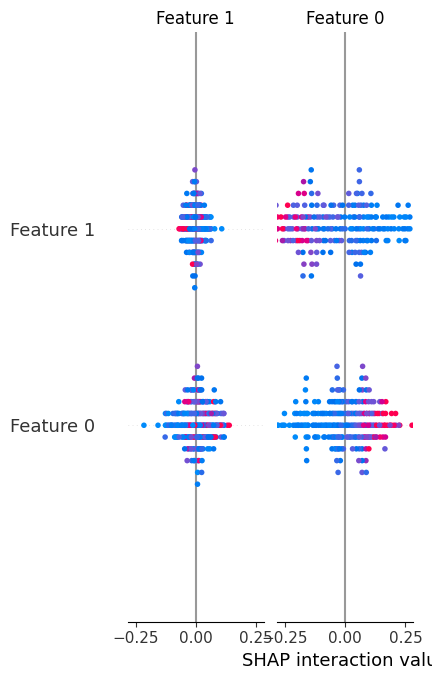

In [ ]:
explainer = shap.TreeExplainer(rf_model_tuned)
shap_values = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, plot_type="bar")

# Select a few individual predictions and explain how each feature contributes to the output using SHAP


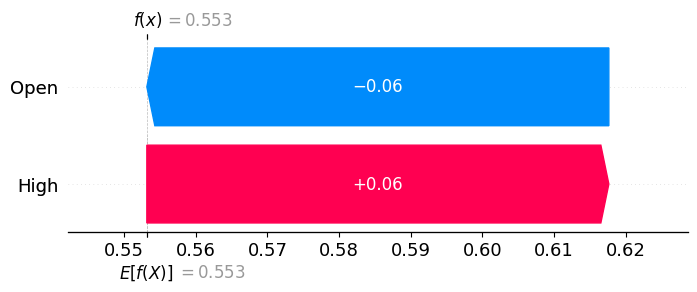

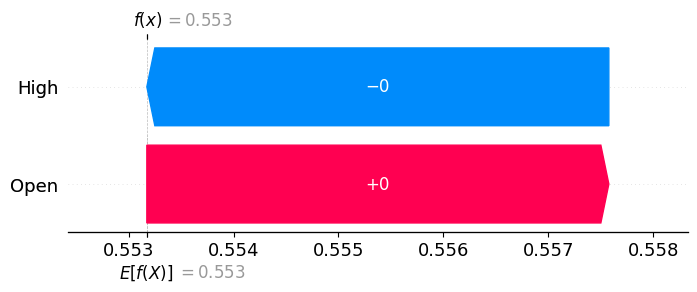

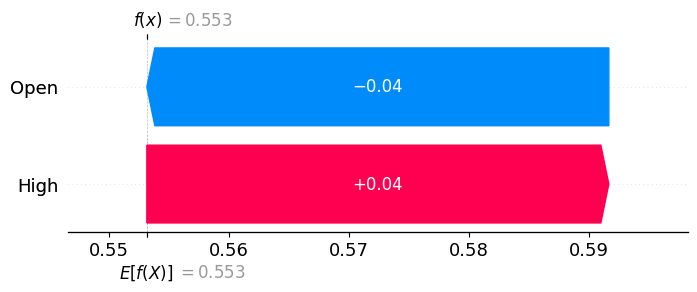

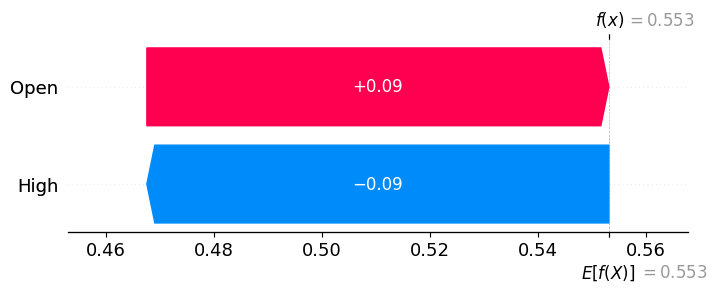

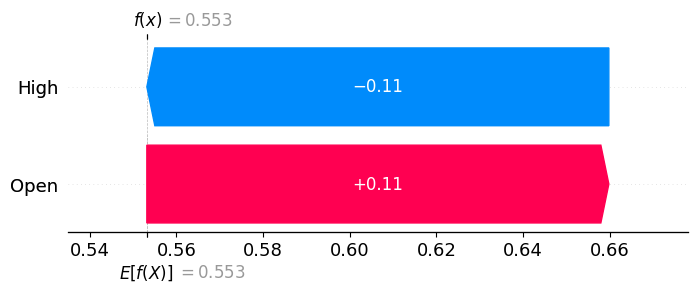

In [ ]:
for i in range(5):
    shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shap_values[1, i, :], feature_names=X_test.columns, max_display=10)


# Use LIME for explanation


In [ ]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train_scaled, feature_names=X_train.columns, class_names=['Down', 'Up'], discretize_continuous=True)


for i in range(5):
    exp = lime_explainer.explain_instance(X_test_scaled[i], rf_model_tuned.predict_proba, num_features=5)
    print("Instance:", i)
    print("Prediction:", rf_model_tuned.predict(X_test_scaled[i].reshape(1, -1)))
    print("Features:")
    for feature, weight in exp.as_list():
        print(feature, weight)


Instance: 0
Prediction: [0]
Features:
Adj Close <= -0.61 -0.19340570989573522
Close <= -0.61 -0.17751958476913765
Low <= -0.60 0.04997129534810145
-0.60 < Open <= -0.25 0.0464984932191765
-0.61 < High <= -0.26 -0.008014590928951355
Instance: 1
Prediction: [0]
Features:
Open <= -0.60 0.274237320634678
Adj Close <= -0.61 -0.182327870952987
Close <= -0.61 -0.1666831379783648
Low <= -0.60 0.04308681956247063
High <= -0.61 0.026688135412368967
Instance: 2
Prediction: [1]
Features:
Open > 0.21 -0.2396984979352666
Adj Close > 0.20 0.17254043352650641
Close > 0.20 0.1601625875525185
Low > 0.21 -0.05163148825549726
High > 0.20 -0.02349971253272018
Instance: 3
Prediction: [1]
Features:
Open <= -0.60 0.27049753612266525
Adj Close <= -0.61 -0.18246165858576444
Close <= -0.61 -0.16835452237032816
Low <= -0.60 0.045463227525896044
High <= -0.61 0.03522151820273601
Instance: 4
Prediction: [0]
Features:
-0.60 < Open <= -0.25 0.06401959301819739
-0.61 < Adj Close <= -0.25 -0.04868432735618523
-0.61 < C

# Compare SHAP and LIME for the same predictions


Comparing SHAP and LIME for Instance 0:

SHAP Explanation:


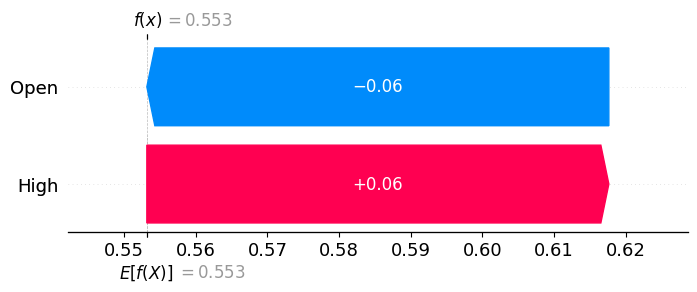


LIME Explanation:
Adj Close <= -0.61: -0.19082825446120402
Close <= -0.61: -0.17995431864007722
-0.60 < Open <= -0.25: 0.055063352871991045
Low <= -0.60: 0.03580385105058493
-0.61 < High <= -0.26: -0.017993652138007514
Comparing SHAP and LIME for Instance 1:

SHAP Explanation:


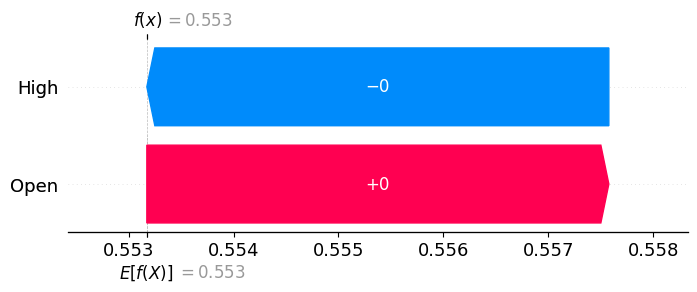


LIME Explanation:
Open <= -0.60: 0.27840366657119736
Adj Close <= -0.61: -0.1869367206835215
Close <= -0.61: -0.16557678483163576
Low <= -0.60: 0.03787586010686614
High <= -0.61: 0.030413005384315572
Comparing SHAP and LIME for Instance 2:

SHAP Explanation:


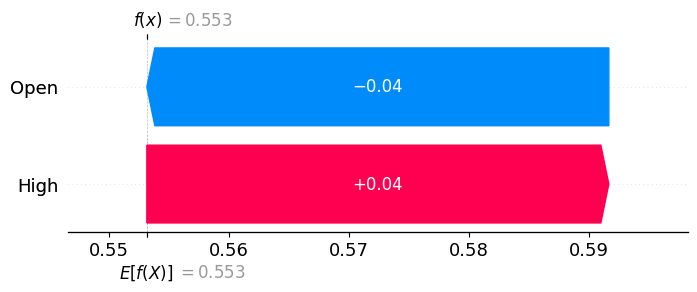


LIME Explanation:
Open > 0.21: -0.24195316213502183
Adj Close > 0.20: 0.16937750652267997
Close > 0.20: 0.15249837981967446
Low > 0.21: -0.048874197526813414
High > 0.20: -0.0217738107545271
Comparing SHAP and LIME for Instance 3:

SHAP Explanation:


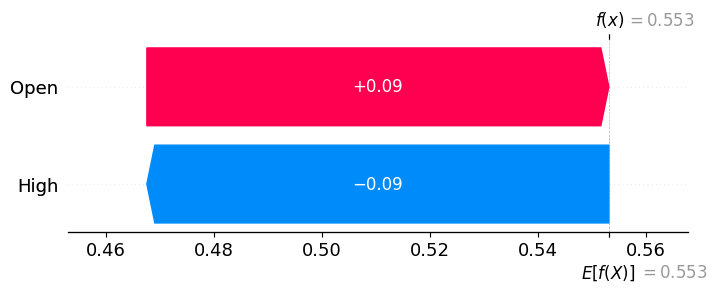


LIME Explanation:
Open <= -0.60: 0.27973278227577
Adj Close <= -0.61: -0.1896469544904713
Close <= -0.61: -0.16790036481657278
Low <= -0.60: 0.03640959520871197
High <= -0.61: 0.025884311551967066
Comparing SHAP and LIME for Instance 4:

SHAP Explanation:


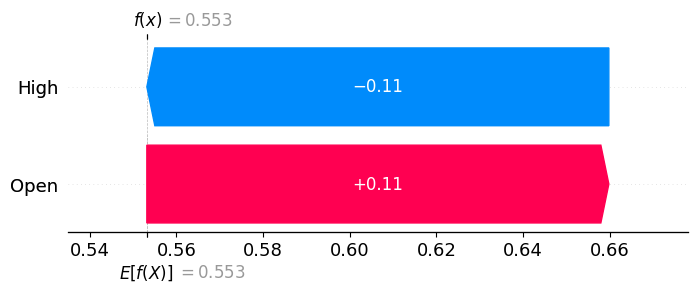


LIME Explanation:
-0.60 < Open <= -0.25: 0.06625274337811356
-0.61 < Close <= -0.25: -0.05149815863293962
-0.61 < Adj Close <= -0.25: -0.03841027190455698
-0.60 < Low <= -0.23: 0.023305039256494145
-0.61 < High <= -0.26: -0.00610425970175665


In [ ]:
for i in range(5):
    print(f"Comparing SHAP and LIME for Instance {i}:")

    print("\nSHAP Explanation:")
    shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shap_values[1, i, :], feature_names=X_test.columns, max_display=10)

    # LIME Explanation
    exp = lime_explainer.explain_instance(X_test_scaled[i], rf_model_tuned.predict_proba, num_features=5)
    print("\nLIME Explanation:")
    for feature, weight in exp.as_list():
        print(f"{feature}: {weight}")


In [ ]:
lime_explanations = []
for i in range(5):
    exp = lime_explainer.explain_instance(X_test_scaled[i], rf_model_tuned.predict_proba, num_features=5)
    lime_explanations.append(exp.as_list())

pd.DataFrame(lime_explanations).to_csv('lime_explanations.csv', index=False)
